# Лабораторная работа №7

### Алипсатарова Карина AIN-2-21

In [1]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import seaborn as sns
import mglearn
import numpy as np
import matplotlib.pyplot as plt

## 2) Создайте свой «мешок слов», например, набор из 20-25 отзывов о чем-либо, напишите краткое пояснение к данным.

In [2]:
# Загрузка отзывов
reviews_train = load_files('reviews/train/')
reviews_test = load_files('reviews/test/')


'''
Декодирование в формат utf-8
В примере мы заменяли [doc.replace(b"<br />", b" ") for doc in text_train], 
но так как в моих документах нет 'br', было принято решение просто перевести в стандартизированный формат.
'''


text_test = [doc.decode('utf-8') for doc in reviews_test.data]
text_train = [doc.decode('utf-8') for doc in reviews_train.data]

y_test, y_train = reviews_test.target, reviews_train.target

print('Тип текстового набора для обучения: \n{}'.format(type(text_train)))
print('Количество текстов в наборе для обучения: \n{}'.format(len(text_train)))
print('Пример текста из обучающего набора:\n{}'.format(text_train[1]))
print("Количество примеров в каждом классе (обучение): {}".format(np.bincount(y_train)))

Тип текстового набора для обучения: 
<class 'list'>
Количество текстов в наборе для обучения: 
20
Пример текста из обучающего набора:
I Would like to start by saying that from seeing commercials for this show It looked to be entertaining. I've always been a fan of Similar shows such as Rick and Morty, Squillbillies, Aqua Team, Futuram and South Park. But this is just down right awful.

The characters voices are more annoying than what I've ever heard on any other animated comedy. This pathetic show tries to take a stab at classic tv shows of the 90's. All of the charectors are just lame alcoholics with nothing interesting going on or anything funny to say.
Количество примеров в каждом классе (обучение): [10 10]


## 3) Создание мешка слов и применение стоп слов 
###### Так как набор данных невелик, значение min_df приведёт к потере ценной информации.
###### Например количество признаков при значении min_df 3 упадет с 1131 до 115

In [3]:
# vect = CountVectorizer(min_df=3, stop_words="english").fit(text_train)
vect = CountVectorizer(stop_words="english").fit(text_train)
X_train = vect.transform(text_train)

print('Размерность мешка слов: {}'.format(X_train.shape))

Размерность мешка слов: (20, 972)


## Информация о признаках

In [4]:
feature_names = vect.get_feature_names_out()

# Выводим информацию о признаках
print("Общее количество признаков: {}".format(len(feature_names)))
print("Первые 20 признаков:\n {}".format(feature_names[:20]))
print("Каждый 25-й признак:\n {}".format(feature_names[::25]))
print("Последние 20 признаков:\n {}".format(feature_names[-20:]))

Общее количество признаков: 972
Первые 20 признаков:
 ['10' '100' '18' '2d' '90' '90s' 'aaron' 'absolute' 'absolutely' 'abuse'
 'abused' 'abusive' 'acceptance' 'accurate' 'achieve' 'achievement'
 'achieves' 'achieving' 'act' 'acted']
Каждый 25-й признак:
 ['10' 'actual' 'anthropomorphic' 'awful' 'blood' 'cage' 'characters'
 'concerns' 'created' 'depicting' 'does' 'emotional' 'evil' 'fame'
 'following' 'genuine' 'hands' 'hope' 'included' 'issues' 'leaving'
 'looks' 'mask' 'moment' 'nguyen' 'overstayed' 'pitchforks' 'presentation'
 'raphael' 'remains' 'sad' 'serve' 'sorry' 'stubbornly' 'surprisingly'
 'thrilled' 'tunes' 'victims' 'wisely']
Последние 20 признаков:
 ['witnessed' 'women' 'won' 'wonder' 'wonderfully' 'words' 'work' 'works'
 'world' 'worship' 'worth' 'worthwhile' 'wrapped' 'write' 'writers'
 'writing' 'written' 'wrote' 'years' 'yes']


## 4) Масштабируйте данные с помощью tf-idf

In [5]:
pipe = make_pipeline(TfidfVectorizer(norm=None), LogisticRegression())

# Параметры
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__max_iter': [10000, 20000, 30000],
    'logisticregression__solver': ['liblinear', 'saga'],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2), (1,3)],
}

grid = GridSearchCV(pipe, param_grid, cv=4)
grid.fit(text_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(norm=None)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'logisticregression__max_iter': [10000, 20000, 30000],
                         'logisticregression__solver': ['liblinear', 'saga'],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [6]:
print('Лучший результат: {:.2f} '.format(grid.best_score_))
print('Лучшие параметры: {}'.format(grid.best_params_))

Лучший результат: 0.85 
Лучшие параметры: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 10000, 'logisticregression__solver': 'liblinear', 'tfidfvectorizer__ngram_range': (1, 1)}


#### 5) Исследуйте коэффициенты модели
##### 40 наибольших и 40 наименьших коэффициентов

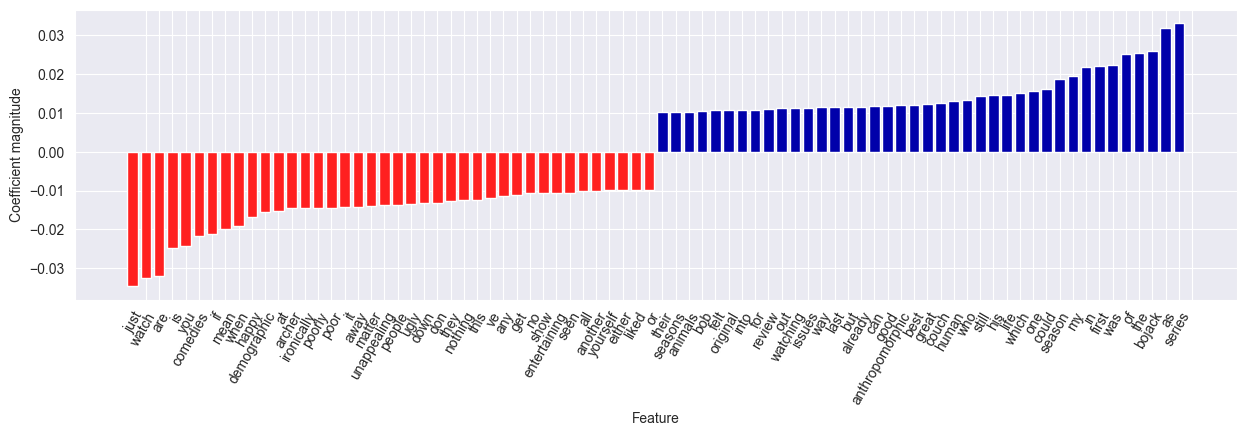

<Figure size 1500x500 with 0 Axes>

In [7]:
vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']

feature_names = np.array(vectorizer.get_feature_names_out())

coefficients = grid.best_estimator_.named_steps['logisticregression'].coef_[0]

mglearn.tools.visualize_coefficients(coefficients, feature_names, n_top_features=40)

plt.figure(figsize=(15, 5))
plt.show()

<h4>Теплокарта для усредненной правильности перекрестной проверки</h4>

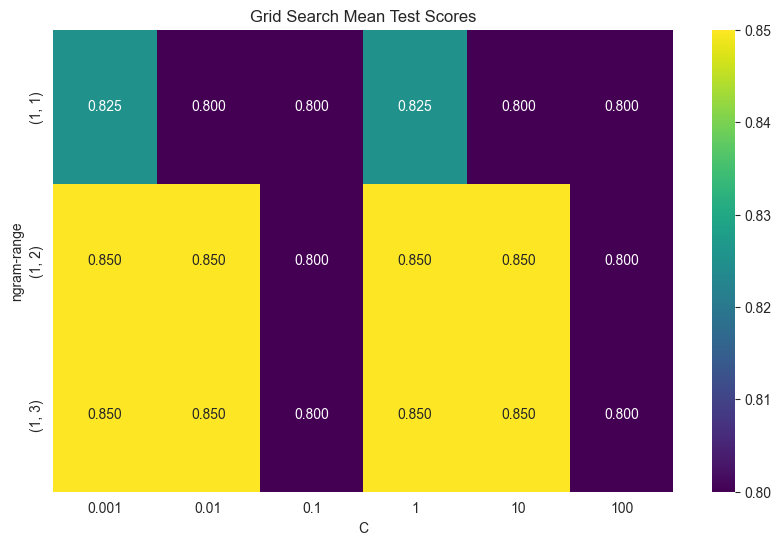

In [8]:
scores = grid.cv_results_['mean_test_score'].reshape(
    len(param_grid['tfidfvectorizer__ngram_range']),
    -1,
    len(param_grid['logisticregression__C'])
)

mean_scores = scores.mean(axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(mean_scores, annot=True, fmt=".3f", cmap='viridis', 
            xticklabels=param_grid['logisticregression__C'],
            yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.xlabel('C')
plt.ylabel('ngram-range')
plt.title('Grid Search Mean Test Scores')
plt.show()

## Отчет

In [9]:
prediction = grid.best_estimator_.predict(text_test)

print(classification_report(y_test, prediction, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5


## 6) Сделайте выводы по работе.

Модель продемонстрировала исключительно высокую производительность на предоставленном наборе данных, достигнув идеальной точности, полноты и F1-меры для обоих классов, с общей точностью 1.00. Однако важно учитывать контекст набора данных и потенциальные искажения или ограничения в процессе оценки.